In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

OSError: [WinError 127] The specified procedure could not be found. Error loading "C:\Users\Ari\anaconda3\envs\tf\lib\site-packages\torch\lib\nvfuser_codegen.dll" or one of its dependencies.

In [10]:
>>> import torch

>>> torch.cuda.is_available()

>>> torch.cuda.device_count()

>>> torch.cuda.current_device()

>>> torch.cuda.device(0)

>>> torch.cuda.get_device_name(0)


OSError: [WinError 127] The specified procedure could not be found. Error loading "C:\Users\Ari\anaconda3\envs\tf\lib\site-packages\torch\lib\nvfuser_codegen.dll" or one of its dependencies.

Exploring the trainingsample CSV dataset:
* "Content": the CEO's announcement
* "Content_Length": the number of words in the CEO's announcement
* "product_related": the label indicating whether the announcement is product-related or not


In [11]:
training_sample = pd.read_csv("Data/trainingsample.csv")
training_sample.head()

,Content,Content_Length,product_related
0,The benefits I think we will see from the chan...,55,No
1,I would just add one more thing. While we shou...,64,No
2,"Ken, I don't have that number at my fingertips...",51,No
3,I think the only part of the segment that I di...,137,Yes
4,"No, nothing has changed. I have been an invest...",75,No


In [28]:
# In the product_related column, convert Yes/No labels to binary 1/0
training_sample = training_sample.replace({'product_related': {'No': 0, 'Yes': 1}})
training_sample.head()

,Content,Content_Length,product_related
0,The benefits I think we will see from the chan...,55,0
1,I would just add one more thing. While we shou...,64,0
2,"Ken, I don't have that number at my fingertips...",51,0
3,I think the only part of the segment that I di...,137,1
4,"No, nothing has changed. I have been an invest...",75,0


In [30]:
# check class distribution
training_sample['product_related'].value_counts(normalize = True)

1    0.58
0    0.42
Name: product_related, dtype: float64

In [33]:
# Split  data into training and testing (80/20)
train_text, temp_text, train_labels, temp_labels = train_test_split(
                                                training_sample['Content'],
                                                training_sample['product_related'],
                                                random_state = 2023,
                                                test_size= 0.2)

# Split the training data into training and validation (again, 80/20 is a fair split).
val_text, test_text, val_labels, test_labels = train_test_split(
                                            temp_text, temp_labels,
                                            random_state = 2023,
                                            test_size= 0.5)

In [36]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

C:\Users\Ari\anaconda3\envs\tf\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Ari\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

<Axes: >

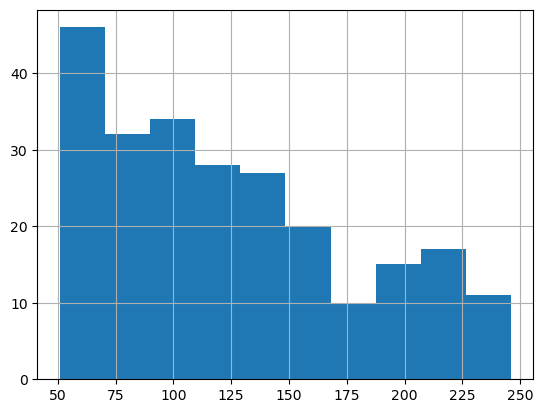

In [40]:
# length of all messages in the dataset
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist()

In [41]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

C:\Users\Ari\anaconda3\envs\tf\lib\site-packages\transformers\tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [43]:
# convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [44]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [45]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [46]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)#%%
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

Exploring the trainingsample CSV dataset:
* "Content": the CEO's announcement
* "Content_Length": the number of words in the CEO's announcement
* "product_related": the label indicating whether the announcement is product-related or not


In [ ]:
training_sample = pd.read_csv("Data/trainingsample.csv")
training_sample.head()

In [ ]:
# In the product_related column, convert Yes/No labels to binary 1/0
training_sample = training_sample.replace({'product_related': {'No': 0, 'Yes': 1}})
training_sample.head()

In [ ]:
# check class distribution
training_sample['product_related'].value_counts(normalize = True)

In [ ]:
# Split  data into training and testing (80/20)
train_text, temp_text, train_labels, temp_labels = train_test_split(
                                                training_sample['Content'],
                                                training_sample['product_related'],
                                                random_state = 2023,
                                                test_size= 0.2)

# Split the training data into training and validation (again, 80/20 is a fair split).
val_text, test_text, val_labels, test_labels = train_test_split(
                                            temp_text, temp_labels,
                                            random_state = 2023,
                                            test_size= 0.5)

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
# length of all messages in the dataset
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist()

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

In [ ]:
# convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [48]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [49]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [50]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)

In [64]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

TypeError: compute_class_weight() takes 1 positional argument but 3 were given

In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 10